## **2. Recursive Feature Elimination**

Conheceremos agora o método **Recursive Feature Elimination** (RFE).

O RFE é um método que se utiliza de um estimador capaz de atribuir um score de **importância** a cada uma das features.

> Por exemplo, podemos olhar para os coeficientes de um modelo linear (`coef_`), ou então, para os scores de importância de features (`feature_importances_`). Esse método só irá funcionar se o estimador escolhido retorna `coef_` ou `feature_importances_`.

O método então considera recursivamente **subconjuntos cada vez menores de features**, da seguinte maneira:

- O estimador é treinado inicialmente com todas as features;
- A importância de cada uma das features é calculada;
- As features menos importantes são retiradas do conjunto de features;
- O processo recomeça, até que o número  desejado de features seja alcançado.

Sendo assim, temos dois hiperparâmetros importantes na classe [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html):

- `estimator`: o estimador que irá disponibilizar os scores de importância de features;
- `n_features_to_select`: a quantidade de features que o subconjunto final terá.

Na prática, podemos utilizar um gridsearch para otimizar estes dois hiperparâmetros, ou então utilizar a classe [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), que determina o melhor número de features automaticamente.



**Exercício 1** Repita o exercício com o dataset `breast_cancer.csv` usando o algoritmo de LASSO para a seleção dos atributos. Realize a tunagem dos hiperparâmetros do estimador do RFE, do estimador base do AdaBoost e do próprio AdaBoost.



In [1]:
import warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#ignorar warnings 
warnings.filterwarnings('ignore')

In [2]:
def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    # =============================================
    print("\nMétricas de avaliação de treino:")
    
    y_pred_train = estimator.predict(X_train)
    
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()
    
    print(classification_report(y_train, y_pred_train))
    
    # ===========================================
    print("\nMétricas de avaliação de teste")
    
    y_pred_test = estimator.predict(X_test)
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()
    
    print(classification_report(y_test, y_pred_test))

In [3]:
# carregar os dados
data = pd.read_csv('breast_cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# extraindo preditores e preditos
x = data.drop(['id', 'diagnosis'], axis=1)
y = data[['diagnosis']]

#transformação do target
y.diagnosis = y.diagnosis.map({'M':1, 'B':0})

In [5]:
# separar o conjunto de treino e de teste
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.3,
    random_state=2,
    stratify=y
)

In [6]:
# configurar o pipeline do modelo
model_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFE(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', random_state=2),
    step=1)),
    ('ada', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(random_state=2)
    ))
])

# dicionário de parâmetros
params = {
    'feature_selector__n_features_to_select': range(1, x_train.shape[1]+1),
    'feature_selector__estimator__C': np.random.uniform(0.001,1,1000),
    'ada__base_estimator__max_depth': range(1,6),
    'ada__n_estimators': np.random.randint(20,501,200)
}


# configurar o validador
cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)

# configurar o buscador
search = RandomizedSearchCV(
    estimator=model_pipe,
    cv=cvs,
    param_distributions=params,
    refit=True,
    n_iter=30,
    scoring='f1',
    random_state=2,
    n_jobs=-1
)

# ajustar o modelo
search.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=2, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('feature_selector',
                                              RFE(estimator=LogisticRegression(penalty='l1',
                                                                               random_state=2,
                                                                               solver='liblinear'))),
                                             ('ada',
                                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2)))]),
                   n_iter=30, n_jobs=-1,
                   param_distr...
       0.05852624, 0.31408182, 0.36676533, 0.77142071, 0.16561659,
       0.40939611, 0.37536429, 0.59206984, 0.62517684, 0.3330252 ,
       0.88253244, 0.31263036, 0.91462757, 0.15651302, 0.59093813,
       0.37472586, 0.29478863, 0.85

In [7]:
# verificando parâmetros
search.best_params_

{'feature_selector__n_features_to_select': 8,
 'feature_selector__estimator__C': 0.7181086277791255,
 'ada__n_estimators': 65,
 'ada__base_estimator__max_depth': 2}

In [8]:
x_train.shape

(398, 30)


Métricas de avaliação de treino:


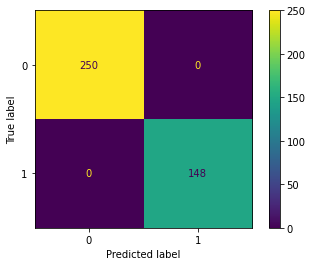

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       148

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398


Métricas de avaliação de teste


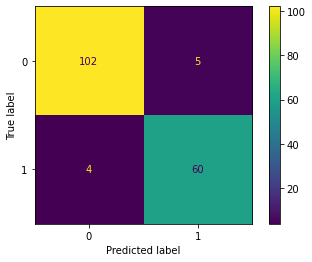

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       107
           1       0.92      0.94      0.93        64

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171



In [9]:
# avaliando o modelo
metricas_classificacao(
    estimator=search.best_estimator_,
    X_train=x_train,
    X_test=x_test,
    y_train=y_train,
    y_test=y_test
)